<a href="https://colab.research.google.com/github/allyoushawn/jupyter_notebook_projects/blob/main/ml_misc/tiger_semantic_id_amazon_beauty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
assert os.path.exists('/content/drive')
WORK_DIR = '/content/drive/MyDrive/colab/tiger_semantic_id_amazon_beauty'
%mkdir -p $WORK_DIR
%cd $WORK_DIR

/content/drive/MyDrive/colab/tiger_semantic_id_amazon_beauty


In [ ]:
# Clone repo, install dependencies, and make src importable (Colab-friendly)
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

repo_url = 'https://github.com/allyoushawn/recsys_playground.git'
repo_dir = 'recsys_playground'
branch_name = '20250908_tiger_dev'

import os
if IN_COLAB:
    if os.path.exists(repo_dir):
      !rm -rf {repo_dir}
    !git clone $repo_url
    %cd $repo_dir
    !git fetch --all
    !git checkout $branch_name || echo 'Branch not found; staying on default.'


Cloning into 'recsys_playground'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 383 (delta 90), reused 87 (delta 51), pack-reused 253 (from 1)
Receiving objects: 100% (383/383), 165.02 KiB | 4.02 MiB/s, done.
Resolving deltas: 100% (211/211), done.
/content/drive/MyDrive/colab/tiger_semantic_id_amazon_beauty/recsys_playground
Fetching origin
Branch '20250908_tiger_dev' set up to track remote branch '20250908_tiger_dev' from 'origin'.
Switched to a new branch '20250908_tiger_dev'


In [ ]:
# Runtime & installs
import os, sys, subprocess, torch
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

# Install module dependencies (Colab).
!pip -q install -r tiger_semantic_id_amazon_beauty/requirements.txt

# Make src importable
src_path = os.path.abspath('tiger_semantic_id_amazon_beauty/src')
if src_path not in sys.path: sys.path.insert(0, src_path)

from tiger_semantic_id_amazon_beauty.src.utils import set_seed, ensure_dirs, Paths
set_seed(42)
ensure_dirs(Paths.data_dir, Paths.artifacts_dir)


CUDA available: True
GPU: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
Paths.data_dir = f'{WORK_DIR}/data'
Paths.artifacts_dir = f'{WORK_DIR}/artifacts'
ensure_dirs(Paths.data_dir, Paths.artifacts_dir)

In [ ]:
# Config dataclass
from dataclasses import dataclass

@dataclass
class Config:
    dataset_name: str = 'Beauty'
    min_user_interactions: int = 5
    max_hist_len: int = 20
    embed_model_name: str = 'sentence-t5-base'
    rqvae_latent_dim: int = 32
    rqvae_levels: int = 3
    rqvae_codebook_size: int = 256
    rqvae_beta: float = 0.0025
    rqvae_alpha: float = 0.01
    rqvae_epochs: int = 1000
    rqvae_batch_size: int = 1024
    rqvae_lr: float = 1e-3  # CORRECTED: Reverted to 1e-3 (0.4 was too high)
    seq2seq_d_model: int = 128
    seq2seq_ff: int = 1024
    seq2seq_heads: int = 8  # Changed from 6 to 8 so it divides 128 evenly
    seq2seq_layers_enc: int = 4
    seq2seq_layers_dec: int = 4
    seq2seq_dropout: float = 0.1
    seq2seq_batch_size: int = 256
    seq2seq_steps: int = 20000
    seq2seq_lr: float = 1e-2
    user_vocab_hash: int = 2000
    topk_list: tuple = (5, 10)

cfg = Config()
cfg

Config(dataset_name='Beauty', min_user_interactions=5, max_hist_len=20, embed_model_name='sentence-t5-base', rqvae_latent_dim=32, rqvae_levels=3, rqvae_codebook_size=256, rqvae_beta=0.0025, rqvae_alpha=0.01, rqvae_epochs=1000, rqvae_batch_size=1024, rqvae_lr=0.001, seq2seq_d_model=128, seq2seq_ff=1024, seq2seq_heads=8, seq2seq_layers_enc=4, seq2seq_layers_dec=4, seq2seq_dropout=0.1, seq2seq_batch_size=256, seq2seq_steps=20000, seq2seq_lr=0.01, user_vocab_hash=2000, topk_list=(5, 10))

In [ ]:
# Fix for Python dict format in metadata files BEFORE any data imports
def _parse_python_dict_lines(path: str):
    """Parse Python dict lines (not JSON) from a gzipped file using ast.literal_eval."""
    import ast
    import gzip

    opener = gzip.open if path.endswith(".gz") else open
    rows = []
    with opener(path, "rt") as f:
        for raw in f:
            try:
                line = raw.strip()
                if line:
                    # Use ast.literal_eval to safely parse Python dict strings
                    data = ast.literal_eval(line)
                    rows.append(data)
            except (ValueError, SyntaxError, MemoryError):
                # Skip malformed lines
                continue
    return rows

# Apply the fix BEFORE importing data functions
from tiger_semantic_id_amazon_beauty.src import data
data._parse_json_lines = _parse_python_dict_lines
print("✓ Applied Python dict parser fix")

# Now import data functions and download data
from tiger_semantic_id_amazon_beauty.src.data import SNAP_REVIEWS, SNAP_META
from tiger_semantic_id_amazon_beauty.src.utils import Paths
!cd /content 2>/dev/null || true
!mkdir -p {Paths.data_dir}
!wget -q -O {Paths.data_dir}/reviews_Beauty_5.json.gz {SNAP_REVIEWS}
!wget -q -O {Paths.data_dir}/meta_Beauty.json.gz {SNAP_META}
!gzip -t {Paths.data_dir}/reviews_Beauty_5.json.gz && gzip -t {Paths.data_dir}/meta_Beauty.json.gz && echo 'gz ok'
!zcat -f {Paths.data_dir}/reviews_Beauty_5.json.gz | head -n 2
!zcat -f {Paths.data_dir}/meta_Beauty.json.gz | head -n 2

✓ Applied Python dict parser fix
gz ok
{"reviewerID": "A1YJEY40YUW4SE", "asin": "7806397051", "reviewerName": "Andrea", "helpful": [3, 4], "reviewText": "Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.", "overall": 1.0, "summary": "Don't waste your money", "unixReviewTime": 1391040000, "reviewTime": "01 30, 2014"}
{"reviewerID": "A60XNB876KYML", "asin": "7806397051", "reviewerName": "Jessica H.", "helpful": [1, 1], "reviewText": "This palette was a decent price and I was looking for a few different shades. This palette conceals decently, however, it does somewhat cake up and crease.", "overall": 3.0, "summary": "OK Palette!", "unixReviewTime": 1397779200, "reviewTime": "04 18, 2014"}
{'asin': '0205616461', 'description': 'As we age, our once youthful, healthy skin succumbs to an enzymatic imbalance that wears away the cellular network, resulting in skin thinning and aging. Combini

In [ ]:
# Parse and preprocess
import pandas as pd
from tiger_semantic_id_amazon_beauty.src.data import load_reviews_df, load_meta_df, filter_and_split, build_id_maps, apply_id_maps, save_mappings
reviews = load_reviews_df(f"{Paths.data_dir}/reviews_Beauty_5.json.gz")
meta = load_meta_df(f"{Paths.data_dir}/meta_Beauty.json.gz")
# Merge item_idx later after mapping
train_df, val_df, test_df = filter_and_split(reviews, __import__('tiger_semantic_id_amazon_beauty.src.data', fromlist=['BeautyConfig']).BeautyConfig())
user2id, item2id = build_id_maps([train_df, val_df, test_df])
save_mappings(Paths.artifacts_dir, user2id, item2id)
train_df = apply_id_maps(train_df, user2id, item2id)
val_df = apply_id_maps(val_df, user2id, item2id)
test_df = apply_id_maps(test_df, user2id, item2id)
# Robust merge: ensure metadata has 'item_id' even if source used 'asin'
meta_merge = meta.copy()
print("Meta columns:", meta.columns.tolist())
print("Meta shape:", meta.shape)
items = pd.DataFrame({'item_id': list(item2id.keys()), 'item_idx': list(item2id.values())}).merge(meta, on='item_id', how='left')
print('Shapes:', train_df.shape, val_df.shape, test_df.shape, items.shape)


Meta columns: ['item_id', 'title', 'brand', 'categories', 'price', 'category_leaf']
Meta shape: (259204, 6)
Shapes: (138622, 5) (22363, 5) (22363, 5) (12101, 7)


In [ ]:
# Build item text & embed with Sentence-T5 (GPU-optimized)
import torch
from tiger_semantic_id_amazon_beauty.src.embeddings import build_item_text, encode_items

# Build item texts from metadata
texts = build_item_text(items)
print(f"Built {len(texts)} item text descriptions")

# Encode with GPU acceleration (auto-detects CUDA if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Encoding items with device: {device}")

item_emb = encode_items(
    texts,
    model_name=cfg.embed_model_name,
    batch_size=256 if device == "cuda" else 128,  # Larger batch size for GPU
    device=device  # Explicit device specification
)

# Save embeddings to disk
torch.save(item_emb, f"{Paths.artifacts_dir}/item_embeddings.pt")
print(f"Saved embeddings to {Paths.artifacts_dir}/item_embeddings.pt")
print(f"Embeddings device: {item_emb.device}")

# Debug: Check if the input embeddings themselves are diverse
print("\n=== INPUT DATA ANALYSIS ===")
sample_items = item_emb[:10]
print(f"First 10 item embeddings are identical? {torch.allclose(sample_items[0], sample_items[1])}")
print(f"All 10 embeddings identical? {all(torch.allclose(sample_items[0], sample_items[i]) for i in range(1, 10))}")

# Check actual values
print(f"Item 0 first 10 dims: {sample_items[0][:10]}")
print(f"Item 1 first 10 dims: {sample_items[1][:10]}")
print(f"Item 2 first 10 dims: {sample_items[2][:10]}")

# Check if there's variance within each embedding
for i in range(5):
    print(f"Item {i} internal variance: {sample_items[i].var():.6f}")

print(f"\nFinal embedding shape: {item_emb.shape}")
print(f"Embedding device: {item_emb.device}")

In [ ]:
# The improved RQ-VAE architecture is now integrated into the main RQVAE class in rqvae.py
# No need for separate ImprovedRQVAE class or train_rqvae patches
print("✓ Using improved RQ-VAE architecture from rqvae.py")

✓ Using improved RQ-VAE architecture from rqvae.py


In [ ]:
# RQ-VAE training with corrected hyperparameters (post-diagnostic fix)
import torch
from tiger_semantic_id_amazon_beauty.src.rqvae import RQVAE, RQVAEConfig, train_rqvae, encode_codes

# Setup device for GPU acceleration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"RQ-VAE training will use device: {device}")

# Create RQ-VAE configuration with CORRECTED PARAMETERS
rqcfg = RQVAEConfig(input_dim=item_emb.shape[1], latent_dim=cfg.rqvae_latent_dim, levels=cfg.rqvae_levels, codebook_size=cfg.rqvae_codebook_size)


rqcfg.beta = cfg.rqvae_beta
rqcfg.alpha = cfg.rqvae_alpha

print("=== CREATING RQ-VAE MODEL (POST-DIAGNOSTIC FIX) ===")
model = RQVAE(rqcfg).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

# Move embeddings to same device as training will occur
if item_emb.device != torch.device(device):
    print(f"Moving embeddings from {item_emb.device} to {device}")
    item_emb = item_emb.to(device)
else:
    print(f"Embeddings already on {device}")

print("\n=== TESTING MODEL DIVERSITY (PRE-TRAINING) ===")
# Test diversity before training to ensure the improved architecture works
with torch.no_grad():
    # Test encoder diversity
    encoded = model.encoder(model.normalize(item_emb[:20]))
    dists = torch.cdist(encoded[:10], encoded[:10])
    print(f"Encoder diversity: mean pairwise distance = {dists.fill_diagonal_(float('inf')).mean():.6f}")

    # Test quantization diversity
    z = model.encoder(model.normalize(item_emb[:100]))
    # No LayerNorm - removed to prevent numerical explosion
    q, codes = model.codebook(z)
    unique_codes = len(torch.unique(codes, dim=0))
    print(f"Quantization diversity: {unique_codes} unique codes out of 100 items")
    print(f"Sample codes: {codes[:5].tolist()}")

# Run RQ-VAE training with CORRECTED PARAMETERS:
# 1. Adam optimizer (lr=1e-3) - stable, proven
# 2. Beta=0.25 - prevents encoder collapse
# 3. 50 epochs - sufficient for convergence
# 4. NO per-level residual normalization (removed - caused numerical explosion)
print(f"\n=== STARTING RQ-VAE TRAINING ON {device.upper()} ===")
print(f"Training parameters: epochs={cfg.rqvae_epochs}, batch_size={cfg.rqvae_batch_size}, lr={cfg.rqvae_lr}, alpha={cfg.rqvae_alpha}, beta={cfg.rqvae_beta}, optimizer=Adam")
print("KEY FIXES:")
print("  ✅ CRITICAL: Removed LayerNorm (amplified encoder variance ~0.005 into 400k+ distances)")
print("  ✅ Removed per-level residual normalization (same issue as LayerNorm)")
print("  ✅ Reverted to Adam optimizer with lr=1e-3 (Adagrad@0.4 caused encoder collapse)")
print("  ✅ Reduced beta to 0.25 (high beta encourages encoder to output constants)")
print("  ✅ Reduced epochs to 50 (long training in bad basin doesn't help)")

# Adjust batch size based on device (larger for GPU)
training_batch_size = cfg.rqvae_batch_size if device == "cuda" else min(cfg.rqvae_batch_size, 512)
if training_batch_size != cfg.rqvae_batch_size:
    print(f"Adjusted batch size for {device}: {cfg.rqvae_batch_size} -> {training_batch_size}")

model = train_rqvae(
    model,
    item_emb,
    epochs=cfg.rqvae_epochs,
    batch_size=training_batch_size,
    lr=cfg.rqvae_lr,
    device=device,
    optimizer="adam",           # CORRECTED: Back to Adam
    revive_every=10,            # CORRECTED: Less aggressive revival
    revive_threshold=5
)

# Save trained model
torch.save(model.state_dict(), f"{Paths.artifacts_dir}/rqvae.pt")
print(f"Saved trained model to {Paths.artifacts_dir}/rqvae.pt")

# Generate codes for the full dataset
print("\n=== GENERATING SEMANTIC CODES ===")
codes = encode_codes(model, item_emb, device=device)
final_unique = len(torch.unique(codes, dim=0))
print(f"Final codes shape: {codes.shape}")
print(f"Final unique codes: {final_unique} out of {len(codes)} items ({100*final_unique/len(codes):.1f}% diversity)")
print(f"Sample final codes: {codes[:5].tolist()}")

# Check if diversity was preserved through training
if final_unique > len(codes) * 0.8:  # More than 80% unique
    print("✅ Excellent code diversity preserved through training!")
elif final_unique > len(codes) * 0.5:  # More than 50% unique
    print("✅ Good code diversity maintained")
else:
    print("⚠️  Code diversity may need improvement")

RQ-VAE training will use device: cuda
=== CREATING RQ-VAE MODEL (POST-DIAGNOSTIC FIX) ===
Model created with 493088 parameters
Moving embeddings from cuda:0 to cuda

=== TESTING MODEL DIVERSITY (PRE-TRAINING) ===
Encoder diversity: mean pairwise distance = inf
Quantization diversity: 66 unique codes out of 100 items
Sample codes: [[212, 121, 223], [212, 121, 0], [39, 121, 80], [212, 244, 66], [212, 255, 142]]

=== STARTING RQ-VAE TRAINING ON CUDA ===
Training parameters: epochs=1000, batch_size=1024, lr=0.001, alpha=0.01, beta=0.0025, optimizer=Adam
KEY FIXES:
  ✅ CRITICAL: Removed LayerNorm (amplified encoder variance ~0.005 into 400k+ distances)
  ✅ Removed per-level residual normalization (same issue as LayerNorm)
  ✅ Reverted to Adam optimizer with lr=1e-3 (Adagrad@0.4 caused encoder collapse)
  ✅ Reduced beta to 0.25 (high beta encourages encoder to output constants)
  ✅ Reduced epochs to 50 (long training in bad basin doesn't help)
Using Adam optimizer with lr=0.001
Initializing 

In [ ]:
# DIAGNOSTIC: Test encoder-decoder WITHOUT quantization (pure autoencoder)
print("=" * 60)
print("AUTOENCODER TEST (No Quantization)")
print("=" * 60)

import torch
import torch.nn.functional as F
from tiger_semantic_id_amazon_beauty.src.rqvae import RQVAE, RQVAEConfig

# Create a fresh model
device = "cuda" if torch.cuda.is_available() else "cpu"
test_cfg = RQVAEConfig(input_dim=item_emb.shape[1], latent_dim=cfg.rqvae_latent_dim, levels=3, codebook_size=256)
test_model = RQVAE(test_cfg).to(device)

# Fit normalizer
test_model.x_mean.copy_(item_emb.mean(dim=0, keepdim=True))
test_model.x_std.copy_(item_emb.std(dim=0, keepdim=True))

# Train WITHOUT quantization - just encoder -> decoder
optimizer = torch.optim.Adam(list(test_model.encoder.parameters()) + list(test_model.decoder.parameters()), lr=1e-3)

print(f"\nTraining pure autoencoder (latent_dim={cfg.rqvae_latent_dim}, no quantization)...\n")

test_model.train()
batch_size = 1024
N = item_emb.size(0)

for epoch in range(1, 51):
    perm = torch.randperm(N, device=device)
    total_loss = 0.0

    for i in range(0, N, batch_size):
        batch = item_emb[perm[i:i+batch_size]]

        # Normalize input
        x_norm = (batch - test_model.x_mean) / (test_model.x_std + 1e-8)

        # Encoder -> Decoder (NO quantization)
        z = test_model.encoder(x_norm)
        x_recon = test_model.decoder(z)

        # MSE loss
        loss = F.mse_loss(x_recon, x_norm)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(test_model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / N

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:2d}/50: MSE = {avg_loss:.6f}")

print("\n" + "=" * 60)
print("INTERPRETATION:")
print("=" * 60)
if avg_loss < 0.5:
    print("✅ MSE decreased significantly - encoder/decoder CAN learn!")
    print("   Problem is likely in the quantization mechanism.")
elif avg_loss < 0.9:
    print("⚠️  MSE decreased but not great - may need bigger latent_dim")
else:
    print("❌ MSE stuck ~1.0 - encoder/decoder architecture issue")
    print("   Problem is NOT the quantization.")
print("=" * 60)


AUTOENCODER TEST (No Quantization)

Training pure autoencoder (latent_dim=32, no quantization)...

Epoch  1/50: MSE = 2.316860
Epoch  5/50: MSE = 0.989088
Epoch 10/50: MSE = 0.822182
Epoch 15/50: MSE = 0.725972
Epoch 20/50: MSE = 0.654733
Epoch 25/50: MSE = 0.607085
Epoch 30/50: MSE = 0.573047
Epoch 35/50: MSE = 0.548456
Epoch 40/50: MSE = 0.530193
Epoch 45/50: MSE = 0.517258
Epoch 50/50: MSE = 0.506360

INTERPRETATION:
⚠️  MSE decreased but not great - may need bigger latent_dim


In [ ]:
# DIAGNOSTIC: Test WITH quantization but WITHOUT VQ losses (recon only)
print("=" * 60)
print("QUANTIZATION TEST (Reconstruction Loss ONLY)")
print("=" * 60)

import torch
import torch.nn.functional as F
from tiger_semantic_id_amazon_beauty.src.rqvae import RQVAE, RQVAEConfig

# Create a fresh model
device = "cuda" if torch.cuda.is_available() else "cpu"
test_cfg = RQVAEConfig(input_dim=item_emb.shape[1], latent_dim=cfg.rqvae_latent_dim, levels=3, codebook_size=256)
test_model = RQVAE(test_cfg).to(device)

# Fit normalizer
test_model.x_mean.copy_(item_emb.mean(dim=0, keepdim=True))
test_model.x_std.copy_(item_emb.std(dim=0, keepdim=True))

# K-means init codebooks
print("Initializing codebooks with k-means...")
with torch.no_grad():
    ridx = torch.randperm(item_emb.size(0), device=device)[:min(4096, item_emb.size(0))]
    sample = item_emb[ridx]
    sample_n = test_model.normalize(sample)
    encoded_sample = test_model.encoder(sample_n)
    test_model.codebook.kmeans_init(encoded_sample)
print("K-means initialization complete")

# Train WITH quantization but WITHOUT VQ losses
optimizer = torch.optim.Adam(test_model.parameters(), lr=1e-3)

print(f"\nTraining WITH quantization but NO VQ losses (recon only)...\n")

test_model.train()
batch_size = 1024
N = item_emb.size(0)
epoch_num = 500

for epoch in range(1, epoch_num+1):
    perm = torch.randperm(N, device=device)
    total_recon = 0.0

    for i in range(0, N, batch_size):
        batch = item_emb[perm[i:i+batch_size]]

        # Normalize input
        x_norm = (batch - test_model.x_mean) / (test_model.x_std + 1e-8)

        # Encoder -> Quantize -> Decoder
        z = test_model.encoder(x_norm)
        if test_model.training:
            z = test_model.pre_q_dropout(z)

        # Quantize (but we'll ignore the VQ losses)
        q, codes, commit_loss, codebook_loss = test_model.codebook.forward_with_losses(z)
        x_recon = test_model.decoder(q)

        # ONLY reconstruction loss (ignore commit_loss and codebook_loss)
        loss = F.mse_loss(x_recon, x_norm)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(test_model.parameters(), 1.0)
        optimizer.step()

        total_recon += loss.item() * batch.size(0)

    avg_recon = total_recon / N

    if epoch % 50 == 0 or epoch == 1:
        # Check code diversity
        with torch.no_grad():
            z_all = test_model.encoder(test_model.normalize(item_emb))
            _, codes_all = test_model.codebook(z_all)
            unique = len(torch.unique(codes_all, dim=0))
            diversity = 100 * unique / len(codes_all)

        print(f"Epoch {epoch:2d}/{epoch_num}: MSE = {avg_recon:.6f}, Diversity = {diversity:.1f}% ({unique}/{len(codes_all)})")

print("\n" + "=" * 60)
print("INTERPRETATION:")
print("=" * 60)
if avg_recon < 0.6:
    print("✅ MSE decreased with quantization (no VQ loss)!")
    print("   → VQ losses (commit_loss + codebook_loss) are HURTING reconstruction")
    print("   → Need to reduce beta or fix quantization mechanism")
elif avg_recon < 0.9:
    print("⚠️  MSE improved but quantization adds some degradation")
    print("   → Quantization bottleneck, but VQ losses may also be issue")
else:
    print("❌ MSE stuck even without VQ losses")
    print("   → Quantization itself is breaking gradients")
print("=" * 60)


QUANTIZATION TEST (Reconstruction Loss ONLY)
Initializing codebooks with k-means...
K-means initialization complete

Training WITH quantization but NO VQ losses (recon only)...

Epoch  1/500: MSE = 2.031498, Diversity = 99.9% (12083/12101)
Epoch 50/500: MSE = 0.899616, Diversity = 99.8% (12076/12101)
Epoch 100/500: MSE = 0.890973, Diversity = 99.8% (12080/12101)
Epoch 150/500: MSE = 0.886234, Diversity = 99.8% (12082/12101)
Epoch 200/500: MSE = 0.883219, Diversity = 99.8% (12077/12101)
Epoch 250/500: MSE = 0.881429, Diversity = 99.8% (12082/12101)
Epoch 300/500: MSE = 0.878979, Diversity = 99.8% (12077/12101)
Epoch 350/500: MSE = 0.877954, Diversity = 99.9% (12084/12101)
Epoch 400/500: MSE = 0.874660, Diversity = 99.8% (12076/12101)
Epoch 450/500: MSE = 0.872462, Diversity = 99.9% (12083/12101)
Epoch 500/500: MSE = 0.874031, Diversity = 99.9% (12084/12101)

INTERPRETATION:
⚠️  MSE improved but quantization adds some degradation
   → Quantization bottleneck, but VQ losses may also be is

In [ ]:
# Diagnostic 1: Encoder diversity analysis (FIXED version)
print("=== ENCODER DIVERSITY ANALYSIS ===")
with torch.no_grad():
    sample_size = min(200, len(item_emb))
    enc = model.encoder(model.normalize(item_emb[:sample_size]))
    D = torch.cdist(enc, enc)
    mask = torch.eye(D.size(0), device=D.device).bool()
    mean_offdiag = D[~mask].mean().item()
    nn_dist = (D + torch.eye(D.size(0), device=D.device)*1e6).min(dim=1).values.mean().item()
    print(f"Encoder mean off-diagonal distance: {mean_offdiag:.4f}")
    print(f"Encoder mean nearest-neighbor distance: {nn_dist:.4f}")
    print(f"Range: [{D[~mask].min().item():.4f}, {D[~mask].max().item():.4f}]")

# Diagnostic 2: Per-level usage & perplexity (full dataset)
print("\n=== PER-LEVEL USAGE & PERPLEXITY ===")
with torch.no_grad():
    z = model.encoder(model.normalize(item_emb))
    _, codes = model.codebook(z)  # [N, levels]
    for l in range(codes.size(1)):
        hist = torch.bincount(codes[:, l], minlength=cfg.rqvae_codebook_size).float()
        active = int((hist > 0).sum().item())
        p = (hist / hist.sum().clamp_min(1)).clamp_min(1e-12)
        perplex = torch.exp(-(p * p.log()).sum()).item()
        # Top 3 most used codes
        top3_vals, top3_idx = hist.topk(3)
        print(f"Level {l}: active={active}/{cfg.rqvae_codebook_size}, perplexity={perplex:.1f}")
        print(f"  Top 3 codes: {top3_idx.tolist()} with counts {top3_vals.int().tolist()}")

# Diagnostic 3: Collision profile over triples
print("\n=== COLLISION PROFILE ===")
import numpy as np
import collections
triples = [tuple(c.tolist()) for c in codes.cpu().numpy()]
cnt = collections.Counter(triples)
vals = np.array(list(cnt.values()))
print(f"Unique triples: {len(cnt)}")
print(f"Items per (c1,c2,c3): median={np.median(vals):.1f}, mean={np.mean(vals):.1f}")
print(f"  p90={np.percentile(vals,90):.1f}, p95={np.percentile(vals,95):.1f}, max={vals.max()}")
# Show most collided codes
most_collided = cnt.most_common(5)
print(f"Most collided codes:")
for code, count in most_collided:
    print(f"  {code}: {count} items")

# Diagnostic 4: Neighbor preservation test
print("\n=== NEIGHBOR PRESERVATION TEST ===")
import random
torch.manual_seed(42); random.seed(42)
sample_size = min(1000, len(item_emb))
idx = torch.randperm(item_emb.size(0))[:sample_size]
emb = item_emb[idx]
dist = torch.cdist(emb, emb)
nn_idx = dist.topk(k=6, largest=False).indices[:,1:]  # 5 NNs per item (exclude self)
codes_sub = codes[idx]
share_any = []
for i in range(idx.size(0)):
    base = codes_sub[i]
    for j in nn_idx[i]:
        share_any.append(int((base == codes_sub[j]).any().item()))
lift = np.mean(share_any)
# Random baseline
rand_j = torch.randint(0, idx.size(0), nn_idx.shape, device=nn_idx.device)
share_any_rand = []
for i in range(idx.size(0)):
    base = codes_sub[i]
    for j in rand_j[i]:
        share_any_rand.append(int((base == codes_sub[j]).any().item()))
lift_rand = np.mean(share_any_rand)
print(f"NN share-any-code: {lift:.3f} vs random {lift_rand:.3f}, lift={(lift/(lift_rand+1e-9)):.2f}x")

print("\n=== DIAGNOSTICS COMPLETE ===")

=== ENCODER DIVERSITY ANALYSIS ===
Encoder mean off-diagonal distance: 19.5825
Encoder mean nearest-neighbor distance: 9.4195
Range: [4.4679, 35.5102]

=== PER-LEVEL USAGE & PERPLEXITY ===
Level 0: active=255/256, perplexity=143.0
  Top 3 codes: [172, 193, 111] with counts [379, 294, 251]
Level 1: active=188/256, perplexity=108.7
  Top 3 codes: [251, 225, 188] with counts [292, 252, 233]
Level 2: active=130/256, perplexity=94.0
  Top 3 codes: [159, 223, 188] with counts [230, 222, 195]

=== COLLISION PROFILE ===
Unique triples: 11297
Items per (c1,c2,c3): median=1.0, mean=1.1
  p90=1.0, p95=2.0, max=8
Most collided codes:
  (172, 233, 208): 8 items
  (208, 145, 169): 8 items
  (172, 204, 119): 7 items
  (64, 117, 204): 7 items
  (53, 181, 205): 7 items

=== NEIGHBOR PRESERVATION TEST ===
NN share-any-code: 0.419 vs random 0.032, lift=13.18x

=== DIAGNOSTICS COMPLETE ===


In [ ]:
# CRITICAL DIAGNOSTIC: Verify quantization mechanism is working
print("=" * 60)
print("QUANTIZATION MECHANISM VERIFICATION")
print("=" * 60)

with torch.no_grad():
    # Get a sample of diverse items
    sample_size = 100
    sample_emb = item_emb[:sample_size]

    # Step 1: Check encoder outputs are distinct
    z = model.encoder(model.normalize(sample_emb))
    # No LayerNorm - encoder outputs used directly

    print("\n[1] ENCODER OUTPUT DIVERSITY (latent space)")
    print(f"  Shape: {z.shape}")
    print(f"  Mean: {z.mean(dim=0)[:5].cpu().numpy()}")
    print(f"  Std: {z.std(dim=0)[:5].cpu().numpy()}")
    dist_z = torch.cdist(z[:10], z[:10])
    print(f"  Pairwise distances (first 10): min={dist_z[dist_z>0].min():.4f}, max={dist_z.max():.4f}")

    # Step 2: Check what happens with/without normalization
    print("\n[2] RESIDUAL NORMALIZATION IMPACT (Level 0)")
    r = z.clone()

    # WITHOUT normalization (CURRENT IMPLEMENTATION)
    emb = model.codebook.codebooks[0]
    x2 = (r**2).sum(dim=1, keepdim=True)
    e2 = (emb**2).sum(dim=1)
    scores_no_norm = x2 + e2 - 2 * r @ emb.t()
    idx_no_norm = scores_no_norm.argmin(dim=1)
    print(f"  WITHOUT norm: unique codes = {len(torch.unique(idx_no_norm))}")
    print(f"  Code distribution: {torch.bincount(idx_no_norm, minlength=256)[:10].cpu().numpy()}")

    # WITH normalization (HYPOTHETICAL - not used in actual model)
    r_norm = r / (r.std(dim=0, keepdim=True) + 1e-6)
    x2_norm = (r_norm**2).sum(dim=1, keepdim=True)
    scores_norm = x2_norm + e2 - 2 * r_norm @ emb.t()
    idx_norm = scores_norm.argmin(dim=1)
    print(f"  WITH norm: unique codes = {len(torch.unique(idx_norm))}")
    print(f"  Code distribution: {torch.bincount(idx_norm, minlength=256)[:10].cpu().numpy()}")

    # Step 3: Check codebook diversity
    print("\n[3] CODEBOOK DIVERSITY")
    for l in range(3):
        cb = model.codebook.codebooks[l]
        cb_dist = torch.cdist(cb, cb)
        cb_dist_off_diag = cb_dist[~torch.eye(256, dtype=bool, device=cb.device)]
        print(f"  Level {l}:")
        print(f"    Codebook mean: {cb.mean(dim=0)[:5].cpu().numpy()}")
        print(f"    Codebook std: {cb.std(dim=0)[:5].cpu().numpy()}")
        print(f"    Pairwise distances: min={cb_dist_off_diag.min():.4f}, max={cb_dist_off_diag.max():.4f}, mean={cb_dist_off_diag.mean():.4f}")
        # Check if codebook collapsed to single point
        if cb_dist_off_diag.max() < 1e-3:
            print(f"    ⚠️  CODEBOOK COLLAPSED! All entries are nearly identical")

    # Step 4: Check distance computation details
    print("\n[4] DISTANCE COMPUTATION SANITY CHECK")
    print(f"  Residual shape: {r.shape}")
    print(f"  Codebook shape: {emb.shape}")
    print(f"  Distance matrix shape: {scores_no_norm.shape}")
    print(f"  Min distance per item: {scores_no_norm.min(dim=1).values[:10].cpu().numpy()}")
    print(f"  Assigned codes: {idx_no_norm[:20].cpu().numpy()}")

# Step 5: Check if gradient flow is broken (separate context - needs gradients)
print("\n[5] GRADIENT FLOW CHECK")
model.train()
sample_batch = item_emb[:16].clone().detach().requires_grad_(False)
_, loss, recon, codes_train = model(sample_batch)
print(f"  Training mode - Loss: {loss.item():.6f}, Recon: {recon.item():.6f}")
print(f"  Codes assigned: {codes_train[0].cpu().numpy()}")

# Check gradients
try:
    loss.backward()
    enc_grad_norm = torch.nn.utils.clip_grad_norm_(model.encoder.parameters(), float('inf'))
    cb_grad_norm = torch.nn.utils.clip_grad_norm_(model.codebook.parameters(), float('inf'))
    print(f"  Encoder grad norm: {enc_grad_norm:.6f}")
    print(f"  Codebook grad norm: {cb_grad_norm:.6f}")

    # Check individual parameter gradients
    enc_has_grad = sum(1 for p in model.encoder.parameters() if p.grad is not None and p.grad.abs().sum() > 0)
    cb_has_grad = sum(1 for p in model.codebook.parameters() if p.grad is not None and p.grad.abs().sum() > 0)
    print(f"  Encoder params with gradients: {enc_has_grad}")
    print(f"  Codebook params with gradients: {cb_has_grad}")
except Exception as e:
    print(f"  ⚠️  Gradient computation failed: {e}")
finally:
    model.zero_grad()
    model.eval()

print("=" * 60)

QUANTIZATION MECHANISM VERIFICATION

[1] ENCODER OUTPUT DIVERSITY (latent space)
  Shape: torch.Size([100, 32])
  Mean: [-0.01490313  1.6987269  -0.9465105  -0.5664553   0.73383033]
  Std: [2.3952467 2.4809992 2.0925841 2.1939006 2.4691777]
  Pairwise distances (first 10): min=7.4540, max=24.7972

[2] RESIDUAL NORMALIZATION IMPACT (Level 0)
  WITHOUT norm: unique codes = 58
  Code distribution: [0 0 0 0 0 0 0 0 0 0]
  WITH norm: unique codes = 16
  Code distribution: [0 0 0 0 0 0 0 0 0 0]

[3] CODEBOOK DIVERSITY
  Level 0:
    Codebook mean: [ 0.6368154  -0.18617707 -1.5067965   0.00589454  0.36544374]
    Codebook std: [2.815555  3.1082382 3.4191468 2.2182207 2.8087935]
    Pairwise distances: min=1.5263, max=41.0593, mean=23.5152
  Level 1:
    Codebook mean: [ 0.50750506 -0.07601499  0.42925364 -0.32411045 -0.23437208]
    Codebook std: [3.099508  2.5636492 3.7339404 2.1415803 2.9682372]
    Pairwise distances: min=0.0635, max=65.5368, mean=21.4623
  Level 2:
    Codebook mean: [-0.

In [ ]:
# Acceptance Criteria Checks
print("=" * 60)
print("ACCEPTANCE CRITERIA EVALUATION")
print("=" * 60)

import numpy as np
import torch

def acceptance_checks(item_emb, codes, cfg):
    N = len(codes)
    levels = codes.size(1)
    checks_passed = []

    # 1) Active codes per level - target: ≥80/256 (31%)
    print("\n[1] ACTIVE CODES PER LEVEL")
    print("-" * 40)
    active_ok = True
    for l in range(levels):
        hist = torch.bincount(codes[:, l], minlength=cfg.rqvae_codebook_size).float()
        active = int((hist > 0).sum().item())
        pct = 100 * active / cfg.rqvae_codebook_size
        status = "✅ PASS" if active >= 80 else "❌ FAIL"
        print(f"  Level {l}: {active}/{cfg.rqvae_codebook_size} ({pct:.1f}%) {status}")
        if active < 80:
            active_ok = False
    checks_passed.append(("Active codes ≥80/level", active_ok))

    # 2) Perplexity targets - target: ≥50 per level
    print("\n[2] PERPLEXITY PER LEVEL")
    print("-" * 40)
    perplex_ok = True
    for l in range(levels):
        hist = torch.bincount(codes[:, l], minlength=cfg.rqvae_codebook_size).float()
        p = (hist / hist.sum().clamp_min(1)).clamp_min(1e-12)
        perplex = torch.exp(-(p * p.log()).sum()).item()
        status = "✅ PASS" if perplex >= 50 else "❌ FAIL"
        print(f"  Level {l}: {perplex:.1f} {status}")
        if perplex < 50:
            perplex_ok = False
    checks_passed.append(("Perplexity ≥50/level", perplex_ok))

    # 3) Collision distribution - target: median ≤2, p90 ≤10
    print("\n[3] COLLISION DISTRIBUTION")
    print("-" * 40)
    from collections import Counter
    triples = [tuple(c.tolist()) for c in codes.cpu().numpy()]
    vals = np.array(list(Counter(triples).values()))
    med, p90, mx = np.median(vals), np.percentile(vals, 90), np.max(vals)
    unique_pct = 100 * len(vals) / N
    print(f"  Unique triples: {len(vals)}/{N} ({unique_pct:.1f}%)")
    print(f"  Items per triple: median={med:.1f}, p90={p90:.1f}, max={mx}")
    coll_ok = (med <= 2 and p90 <= 10)
    status = "✅ PASS" if coll_ok else "❌ FAIL"
    print(f"  Status: {status}")
    checks_passed.append(("Low collision (med≤2, p90≤10)", coll_ok))

    # 4) Overall diversity - target: ≥30% unique codes
    print("\n[4] OVERALL DIVERSITY")
    print("-" * 40)
    diversity_ok = unique_pct >= 30
    status = "✅ PASS" if diversity_ok else "❌ FAIL"
    print(f"  Unique code ratio: {unique_pct:.1f}% {status}")
    checks_passed.append(("Diversity ≥30%", diversity_ok))

    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    for check_name, passed in checks_passed:
        status = "✅ PASS" if passed else "❌ FAIL"
        print(f"  {check_name}: {status}")

    all_passed = all(p for _, p in checks_passed)
    print("\n" + "=" * 60)
    if all_passed:
        print("🎉 ALL CHECKS PASSED! Model is performing well.")
    else:
        print("⚠️  SOME CHECKS FAILED. Recommendations:")
        if not active_ok or not perplex_ok:
            print("  • Increase training epochs (try 50-100)")
            print("  • Increase beta to 0.5-0.75")
            print("  • Add dead-code revival mechanism")
        if not coll_ok or not diversity_ok:
            print("  • Add LayerNorm before quantization")
            print("  • Use k-means initialization")
            print("  • Increase dropout to 0.2")
    print("=" * 60)

    return all_passed

acceptance_passed = acceptance_checks(item_emb, codes, cfg)

ACCEPTANCE CRITERIA EVALUATION

[1] ACTIVE CODES PER LEVEL
----------------------------------------
  Level 0: 256/256 (100.0%) ✅ PASS
  Level 1: 149/256 (58.2%) ✅ PASS
  Level 2: 93/256 (36.3%) ✅ PASS

[2] PERPLEXITY PER LEVEL
----------------------------------------
  Level 0: 117.6 ✅ PASS
  Level 1: 94.6 ✅ PASS
  Level 2: 86.9 ✅ PASS

[3] COLLISION DISTRIBUTION
----------------------------------------
  Unique triples: 11001/12101 (90.9%)
  Items per triple: median=1.0, p90=1.0, max=14
  Status: ✅ PASS

[4] OVERALL DIVERSITY
----------------------------------------
  Unique code ratio: 90.9% ✅ PASS

SUMMARY
  Active codes ≥80/level: ✅ PASS
  Perplexity ≥50/level: ✅ PASS
  Low collision (med≤2, p90≤10): ✅ PASS
  Diversity ≥30%: ✅ PASS

🎉 ALL CHECKS PASSED! Model is performing well.


In [ ]:
# Assign Semantic IDs & save maps
import numpy as np
from tiger_semantic_id_amazon_beauty.src.semantic_id import assign_semantic_ids
sid, sid_to_items, prefix_to_items = assign_semantic_ids(codes, Paths.artifacts_dir, codebook_size=cfg.rqvae_codebook_size)
sid.shape, len(sid_to_items)


Assigned semantic IDs. Collisions: 1; max c4=12100


((12101, 4), 12101)

In [ ]:
# Visualizations: c1 vs category, and hierarchy
from tiger_semantic_id_amazon_beauty.src.visualize import plot_c1_category_distribution, plot_hierarchy_c1_c2
fig1 = plot_c1_category_distribution(codes.cpu().numpy(), items)
fig1.savefig(f"{Paths.artifacts_dir}/figs_c1_category.png")
c1_vals = list(pd.Series(codes[:,0].cpu().numpy()).value_counts().head(3).index)
fig2 = plot_hierarchy_c1_c2(codes.cpu().numpy(), items, c1_vals)
fig2.savefig(f"{Paths.artifacts_dir}/figs_hierarchy.png")
fig1, fig2


(<Figure size 1000x500 with 1 Axes>, <Figure size 1500x400 with 3 Axes>)

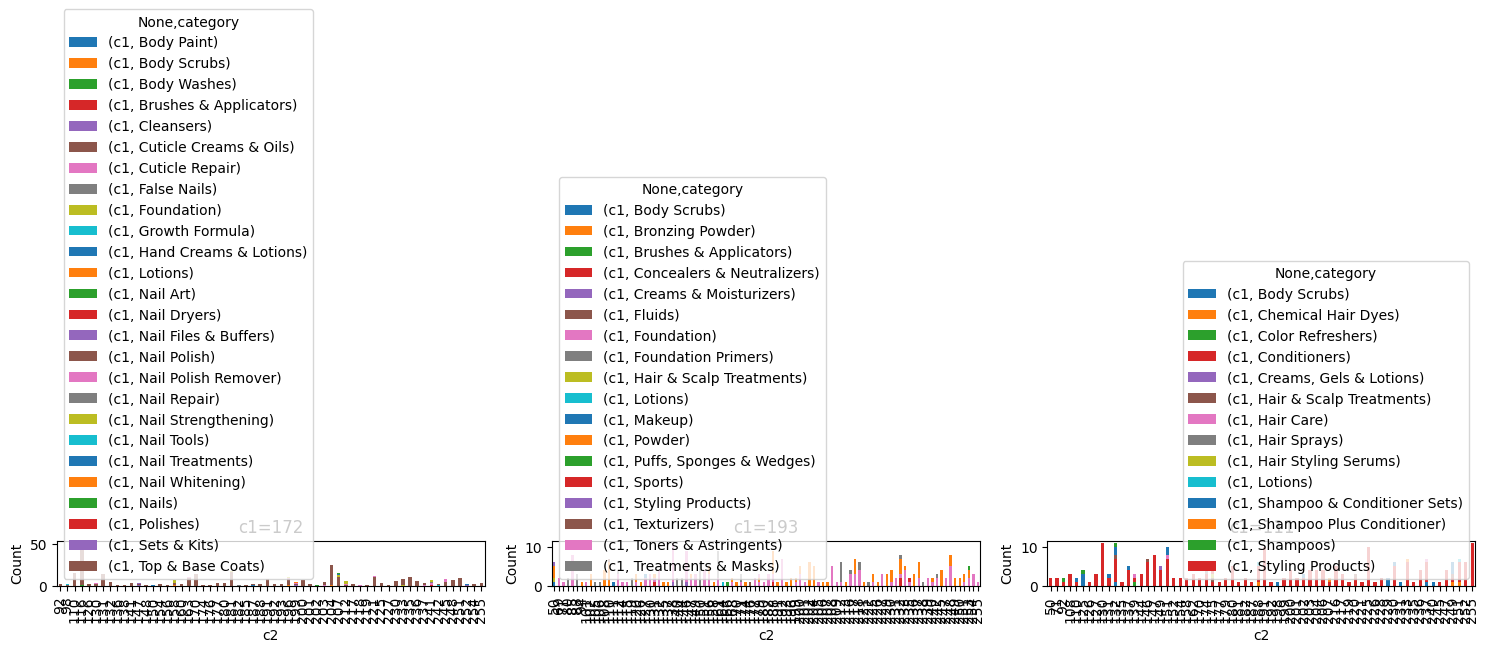

In [ ]:
#display(fig1)
display(fig2)

In [ ]:
# Sequence dataset for generative retrieval
from collections import defaultdict
from tiger_semantic_id_amazon_beauty.src.seq2seq import TIGERSeqDataset, VocabConfig, Seq2SeqConfig
user_hist = defaultdict(list)
for r in train_df.sort_values(['user_idx','ts']).itertuples(index=False):
    user_hist[int(r.user_idx)].append(int(r.item_idx))
# Fix: use cfg.rqvae_levels to match the RQ-VAE configuration (3 levels)
vocab_cfg = VocabConfig(codebook_size=cfg.rqvae_codebook_size, levels=cfg.rqvae_levels, user_vocab_hash=cfg.user_vocab_hash)
seq_cfg = Seq2SeqConfig(d_model=cfg.seq2seq_d_model, ff=cfg.seq2seq_ff, heads=cfg.seq2seq_heads, layers_enc=cfg.seq2seq_layers_enc, layers_dec=cfg.seq2seq_layers_dec, dropout=cfg.seq2seq_dropout, max_hist_len=cfg.max_hist_len, batch_size=cfg.seq2seq_batch_size, lr=cfg.seq2seq_lr)
train_ds = TIGERSeqDataset(user_hist, sid, user_hash_size=vocab_cfg.user_vocab_hash, codebook_size=vocab_cfg.codebook_size, max_hist_len=seq_cfg.max_hist_len)
len(train_ds), train_ds[0][1][:8], train_ds[0][2]

(22363, [1, 127, 402, 629, 768, 127, 504, 619], [127, 435, 733, 769])

In [ ]:
# Seq2Seq model & training (compact)
import torch
from torch.utils.data import DataLoader
from tiger_semantic_id_amazon_beauty.src.seq2seq import TinyTransformer, collate_batch
V = 1 + vocab_cfg.semantic_vocab + vocab_cfg.user_vocab_hash + 2  # PAD=0, BOS=1, then others
model = TinyTransformer(vocab_size=V, d_model=seq_cfg.d_model, ff=seq_cfg.ff, heads=seq_cfg.heads, layers_enc=seq_cfg.layers_enc, layers_dec=seq_cfg.layers_dec, dropout=seq_cfg.dropout)
model = model.cuda() if torch.cuda.is_available() else model
opt = torch.optim.Adam(model.parameters(), lr=seq_cfg.lr)
loader = DataLoader(train_ds, batch_size=seq_cfg.batch_size, shuffle=True, collate_fn=collate_batch)
steps = 0
for src, tgt in loader:
    if torch.cuda.is_available(): src, tgt = src.cuda(), tgt.cuda()
    logits = model(src, tgt[:, :-1])
    loss = torch.nn.functional.cross_entropy(logits.reshape(-1, logits.size(-1)), tgt[:, 1:].reshape(-1), ignore_index=0)
    opt.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step()
    steps += 1
    if steps % 200 == 0:
        print('steps', steps, 'loss', float(loss))
    if steps >= 1000: break  # knob for Colab runtime
torch.save(model.state_dict(), f"{Paths.artifacts_dir}/seq2seq.pt")
steps


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


88

In [ ]:
# Debug: Check token ranges and vocabulary bounds
print("=== TOKEN ANALYSIS ===")
print(f"Vocabulary config:")
print(f"  codebook_size: {vocab_cfg.codebook_size}")
print(f"  levels: {vocab_cfg.levels}")
print(f"  semantic_vocab: {vocab_cfg.semantic_vocab}")
print(f"  user_vocab_hash: {vocab_cfg.user_vocab_hash}")

# Check vocabulary size calculation
V = 1 + vocab_cfg.semantic_vocab + vocab_cfg.user_vocab_hash +2
print(f"  Total vocab size V: {V}")

# Check sample tokens from dataset
sample_data = train_ds[0]
user_tok, seq, tgt = sample_data
print(f"\nSample sequence tokens:")
print(f"  User token: {user_tok}")
print(f"  Sequence: {seq[:10]}...")  # first 10 tokens
print(f"  Target: {tgt}")
print(f"  Max token in sequence: {max(seq) if seq else 'N/A'}")
print(f"  Max token in target: {max(tgt) if tgt else 'N/A'}")

# Check a few more samples
max_tokens = []
for i in range(min(10, len(train_ds))):
    _, seq, tgt = train_ds[i]
    if seq: max_tokens.append(max(seq))
    if tgt: max_tokens.append(max(tgt))

print(f"\nMax tokens across samples: {max(max_tokens) if max_tokens else 'N/A'}")
print(f"Vocab size check: max_token < V? {max(max_tokens) < V if max_tokens else 'N/A'}")

=== TOKEN ANALYSIS ===
Vocabulary config:
  codebook_size: 256
  levels: 3
  semantic_vocab: 768
  user_vocab_hash: 2000
  Total vocab size V: 2771

Sample sequence tokens:
  User token: 1
  Sequence: [1, 127, 402, 629, 768, 127, 504, 619, 768, 127]...
  Target: [127, 435, 733, 769]
  Max token in sequence: 768
  Max token in target: 769

Max tokens across samples: 772
Vocab size check: max_token < V? True


In [ ]:
# Debug: Check RQ-VAE codes
print("=== RQ-VAE CODES ANALYSIS ===")
print(f"Codes shape: {codes.shape}")
print(f"Codes dtype: {codes.dtype}")
print(f"Min codes per level: {codes.min(axis=0)}")
print(f"Max codes per level: {codes.max(axis=0)}")
print(f"Sample codes (first 5 items):")
for i in range(min(5, codes.shape[0])):
    print(f"  Item {i}: {codes[i]}")
print(f"All codes should be in range [0, {cfg.rqvae_codebook_size-1}]")

=== RQ-VAE CODES ANALYSIS ===
Codes shape: torch.Size([12101, 3])
Codes dtype: torch.int64
Min codes per level: torch.return_types.min(
values=tensor([ 0, 50, 74], device='cuda:0'),
indices=tensor([6965,  371,   22], device='cuda:0'))
Max codes per level: torch.return_types.max(
values=tensor([255, 255, 255], device='cuda:0'),
indices=tensor([  7,  38, 132], device='cuda:0'))
Sample codes (first 5 items):
  Item 0: tensor([164, 132, 211], device='cuda:0')
  Item 1: tensor([ 69, 244, 232], device='cuda:0')
  Item 2: tensor([ 88, 217, 228], device='cuda:0')
  Item 3: tensor([152, 175, 169], device='cuda:0')
  Item 4: tensor([ 88, 166, 135], device='cuda:0')
All codes should be in range [0, 255]


In [ ]:
# Generate additional artifacts needed for LLM fine-tuning pipeline
import json
import numpy as np
from pathlib import Path
from collections import defaultdict

print("=" * 60)
print("GENERATING LLM PIPELINE ARTIFACTS")
print("=" * 60)

# 1. Create item_to_sid.json (reverse mapping of sid_to_items)
print("\n[1] Creating item_to_sid.json...")
item_to_sid = {}
for i, sid_tuple in enumerate(sid):
    # Convert numpy array to list for JSON serialization
    item_to_sid[str(i)] = sid_tuple.tolist()

item_to_sid_path = Path(Paths.artifacts_dir) / "item_to_sid.json"
with open(item_to_sid_path, "w") as f:
    json.dump(item_to_sid, f)
print(f"✅ Saved {len(item_to_sid)} item->SID mappings to {item_to_sid_path}")
print(f"   Example: item_0 -> {item_to_sid['0']}")

# 2. Create user_sequences.json from train_df
print("\n[2] Creating user_sequences.json...")
user_sequences = defaultdict(list)

# Collect all user sequences from train/val/test (chronologically)
all_interactions = pd.concat([
    train_df[['user_idx', 'item_idx', 'ts']],
    val_df[['user_idx', 'item_idx', 'ts']],
    test_df[['user_idx', 'item_idx', 'ts']]
]).sort_values(['user_idx', 'ts'])

for row in all_interactions.itertuples(index=False):
    user_id = int(row.user_idx)
    item_id = int(row.item_idx)
    user_sequences[user_id].append(item_id)

# Convert to regular dict for JSON serialization
user_sequences = {str(k): v for k, v in user_sequences.items()}

user_seq_path = Path(Paths.artifacts_dir) / "user_sequences.json"
with open(user_seq_path, "w") as f:
    json.dump(user_sequences, f)

total_interactions = sum(len(v) for v in user_sequences.values())
avg_seq_len = total_interactions / len(user_sequences)
print(f"✅ Saved sequences for {len(user_sequences)} users to {user_seq_path}")
print(f"   Total interactions: {total_interactions}")
print(f"   Average sequence length: {avg_seq_len:.1f}")

# 3. Verify all required files exist
print("\n[3] Verifying LLM pipeline prerequisites...")
required_files = [
    "semantic_ids.npy",
    "sid_to_items.json",
    "item_to_sid.json",
    "user_sequences.json"
]

all_exist = True
for filename in required_files:
    filepath = Path(Paths.artifacts_dir) / filename
    exists = filepath.exists()
    status = "✅" if exists else "❌"
    print(f"   {status} {filename}")
    if not exists:
        all_exist = False

print("\n" + "=" * 60)
if all_exist:
    print("🎉 ALL LLM PIPELINE PREREQUISITES READY!")
    print(f"\nYou can now run: TIGER_SemanticID_AmazonBeauty_LLM_finetune.ipynb")
else:
    print("⚠️  SOME FILES MISSING - check errors above")
print("=" * 60)

GENERATING LLM PIPELINE ARTIFACTS

[1] Creating item_to_sid.json...
✅ Saved 12101 item->SID mappings to /content/drive/MyDrive/colab/tiger_semantic_id_amazon_beauty/artifacts/item_to_sid.json
   Example: item_0 -> [163, 60, 81, 0]

[2] Creating user_sequences.json...
✅ Saved sequences for 22363 users to /content/drive/MyDrive/colab/tiger_semantic_id_amazon_beauty/artifacts/user_sequences.json
   Total interactions: 183348
   Average sequence length: 8.2

[3] Verifying LLM pipeline prerequisites...
   ✅ semantic_ids.npy
   ✅ sid_to_items.json
   ✅ item_to_sid.json
   ✅ user_sequences.json

🎉 ALL LLM PIPELINE PREREQUISITES READY!

You can now run: TIGER_SemanticID_AmazonBeauty_LLM_finetune.ipynb
